<a href="https://colab.research.google.com/github/sankeerthsirikonda/AI_Blog_Content_Assistant/blob/main/Simple_Chat_Bot_With_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached langchain_groq-1.0.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langgraph-1.0.3-py3-none-any.whl.metadata (7.8 kB)
  Using cached rizaio-0.12.0-py3-none-any.whl.metadata (14 kB)
INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with strict

In [4]:
from google.colab import userdata
userdata.get('secretName')

import os
from google.colab import userdata

groq_api_key=userdata.get('Groq')

os.environ["TAVILY_API_KEY"]=userdata.get('Tavily')

In [6]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition

from langchain_community.tools.tavily_search import TavilySearchResults


In [9]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7feb8c9b71d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7feb8cb7d610>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
llm.invoke("hi")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.007188267, 'completion_tokens_details': None, 'prompt_time': 0.001678837, 'prompt_tokens_details': None, 'queue_time': 0.055636113, 'total_time': 0.008867104}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--7826aa7c-e7f9-4ed1-93fb-76eeb506b3c2-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [11]:
tool_tavily=TavilySearchResults(max_results=2)
tools=[tool_tavily]

/tmp/ipython-input-2093692024.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool_tavily=TavilySearchResults(max_results=2)


In [16]:
llm_with_tools=llm.bind_tools(tools=tools)
llm_with_tools.invoke("give me current events in USA")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2yn4s7f9g', 'function': {'arguments': '{"query":"current events USA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 284, 'total_tokens': 304, 'completion_time': 0.033009758, 'completion_tokens_details': None, 'prompt_time': 0.018438048, 'prompt_tokens_details': None, 'queue_time': 0.053367282, 'total_time': 0.051447806}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1e81f3c0-f7e1-4e3b-b34c-3f80ef801577-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current events USA'}, 'id': '2yn4s7f9g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 20, 'total_tokens': 304})

In [29]:
llm_with_tools.invoke(" who is new york of USA")
ans=llm.invoke("who is mayor of new york in USA")
ans.content

'As of my cut-off knowledge in December 2023, the Mayor of New York City is Eric Adams. He is an American politician and the 110th Mayor of New York City, serving since January 1, 2022.'

In [30]:
response = llm.invoke('''### what is the output of print(['a']+[2])''')
if hasattr(response, 'content'):
    print("AI Response Content:", response.content)
else:
    print("AI Response:", response)


AI Response Content: The output of `print(['a']+[2])` will be:

`['a', 2]`

This is because in Python, when you use the `+` operator between a list and a number, the number is automatically converted to a list containing that number. So `2` becomes `'[2]'` which is a list containing the integer `2` and then it gets concatenated with `['a']` and the result is `['a', 2]`. Note that in Python, the number 2 is of type `int` but when it is put into the list it becomes a `int` within the list.


In [31]:
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [33]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [45]:
graph_builder=StateGraph(State)
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")
graph_builder.set_entry_point("chatbot")
graph=graph_builder.compile()

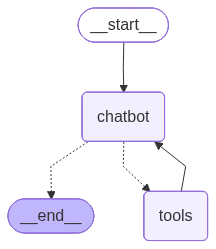

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [49]:
def stream_graph_updates(user_input:str):
  initial_state={"messages":[("user",user_input)]}

  for event in graph.stream(initial_state):
    for value in event.values():
      print("Assistant:",value["messages"][-1].content)




In [50]:
while True:
    try:
        user_input = input("User: ")  # Get user input

        if user_input.lower() in ["quit", "exit", "q"]:  # Check for exit commands
            print("Goodbye!")
            break  # Exit the loop

        stream_graph_updates(user_input)  # Process the user input using the graph
    except Exception as e:  # Catch any exceptions that might occur during input or processing
        print('Exceptions occured during processing:', e)
        stream_graph_updates(user_input)  # Process the default input
        break  # Exit the loop after the fallback

User: who is mayor of newyork
Assistant: 
Assistant: [{"title": "Mayor of New York City - Wikipedia", "url": "https://en.wikipedia.org/wiki/Mayor_of_New_York_City", "content": "The mayor of New York City, officially mayor of the City of New York, is head of the executive branch of the government of New York City and the chief executive of New York City. The mayor's office administers all city services, public property, police and fire protection, and most public agencies, and enforces all city and state laws within New York City. [...] The current mayor is Eric Adams, who was elected on November 2, 2021, and took office shortly after midnight on January 1, 2022. Zohran Mamdani is the mayor-elect, having won the election held on November 4, 2025. Mamdani will take office on January 1, 2026.\n\n## History\n\n[edit]\n\nSee also: List of mayors of New York City [...] In 1665, Governor Richard Nicolls appointed Thomas Willett as the first mayor of New York. For 156 years, the mayor was appo